# Reading cloud radar data
The high resolution data has about 500 MB per file, which when read in over a remote source can lead to long wait times.
To reduce the wait times the data can be read in lazily using dask.
Intake will this do this by default.
Let's obtain the EUREC4A intake catalog:

In [1]:
import eurec4a
cat = eurec4a.get_intake_catalog()

## Available products
The `LIMRAD94` cloud radar offers multiple products which can be accessed using names and additional parameters.
Let's see which products and parameters are available for the cloud radar.
For the parameters, we are also interested in their valid range:

In [2]:
for key, source in cat.Meteor.LIMRAD94.items():
    desc = source.describe()
    user_parameters = desc.get("user_parameters", [])
    if len(user_parameters) > 0:
        params = " (" + ", ".join(p["name"] for p in user_parameters) + ")"
    else:
        params = ""
    print(f"{key}{params}: {desc['description']}")
    for parameter in user_parameters:
        print(f"    {parameter['name']}: {parameter['min']} ... {parameter['max']} default: {parameter['default']}")
    print()

low_res (date): daily 30m 30s averaged radar reflectivity
    date: 2020-01-17 00:00:00 ... 2020-02-29 00:00:00 default: 2020-02-01 00:00:00

high_res (date, version): daily heave corrected original resolution cloudradar data
    date: 2020-01-17 00:00:00 ... 2020-02-29 00:00:00 default: 2020-02-01 00:00:00
    version: 1.0 ... 1.1 default: 1.1



## Radar reflectivity
We'll have a look at the `high_res` data in version 1.1. We'll keep the default date for simplicity:

In [3]:
ds = cat.Meteor.LIMRAD94.high_res(version=1.1).to_dask()
ds

<xarray.Dataset>
Dimensions:                    (chirp: 3, range: 367, time: 44447)
Coordinates:
  * time                       (time) datetime64[ns] 2020-02-01T00:00:06.7000...
  * range                      (range) float32 313.0 335.4 ... 1.296e+04
Dimensions without coordinates: chirp
Data variables: (12/23)
    frequency                  float32 ...
    Numfft                     float32 ...
    altitude                   float32 ...
    NumSpectraAveraged         (chirp) float32 dask.array<chunksize=(3,), meta=np.ndarray>
    latitude                   (time) float32 dask.array<chunksize=(1000,), meta=np.ndarray>
    longitude                  (time) float32 dask.array<chunksize=(1000,), meta=np.ndarray>
    ...                         ...
    width                      (time, range) float32 dask.array<chunksize=(1000, 367), meta=np.ndarray>
    ldr                        (time, range) float32 dask.array<chunksize=(1000, 367), meta=np.ndarray>
    kurt                       (time, range) float32 dask.array<chunksize=(1000, 367), meta=np.ndarray>
    Skew                       (time, range) float32 dask.array<chunksize=(1000, 367), meta=np.ndarray>
    heave_cor                  (time, range) float32 dask.array<chunksize=(1000, 367), meta=np.ndarray>
    heave_cor_bins             (time, range) float64 dask.array<chunksize=(1000, 367), meta=np.ndarray>
Attributes: (12/20)
    Conventions:    CF-1.8
    title:          LIMRAD94 (SLDR) Doppler Cloud Radar, calibrated file
    campaign_id:    EUREC4A
    platform_id:    Meteor
    instrument_id:  LIMRAD94
    version_id:     v1.1
    ...             ...
    description:    Concatenated data files of LIMRAD 94GHz - FMCW Radar, fil...
    history:        Created Thu Feb 18 23:16:55 2021
    _FillValue:     -999.0
    day:            1
    month:          2
    year:           2020

Explore the dataset and choose the variable you want to work with.
The variables are loaded lazily, i.e. only when their content is really required to complete the operation.
An example which forces the data to load is plotting, in this case only the radar reflectivity will be loaded.

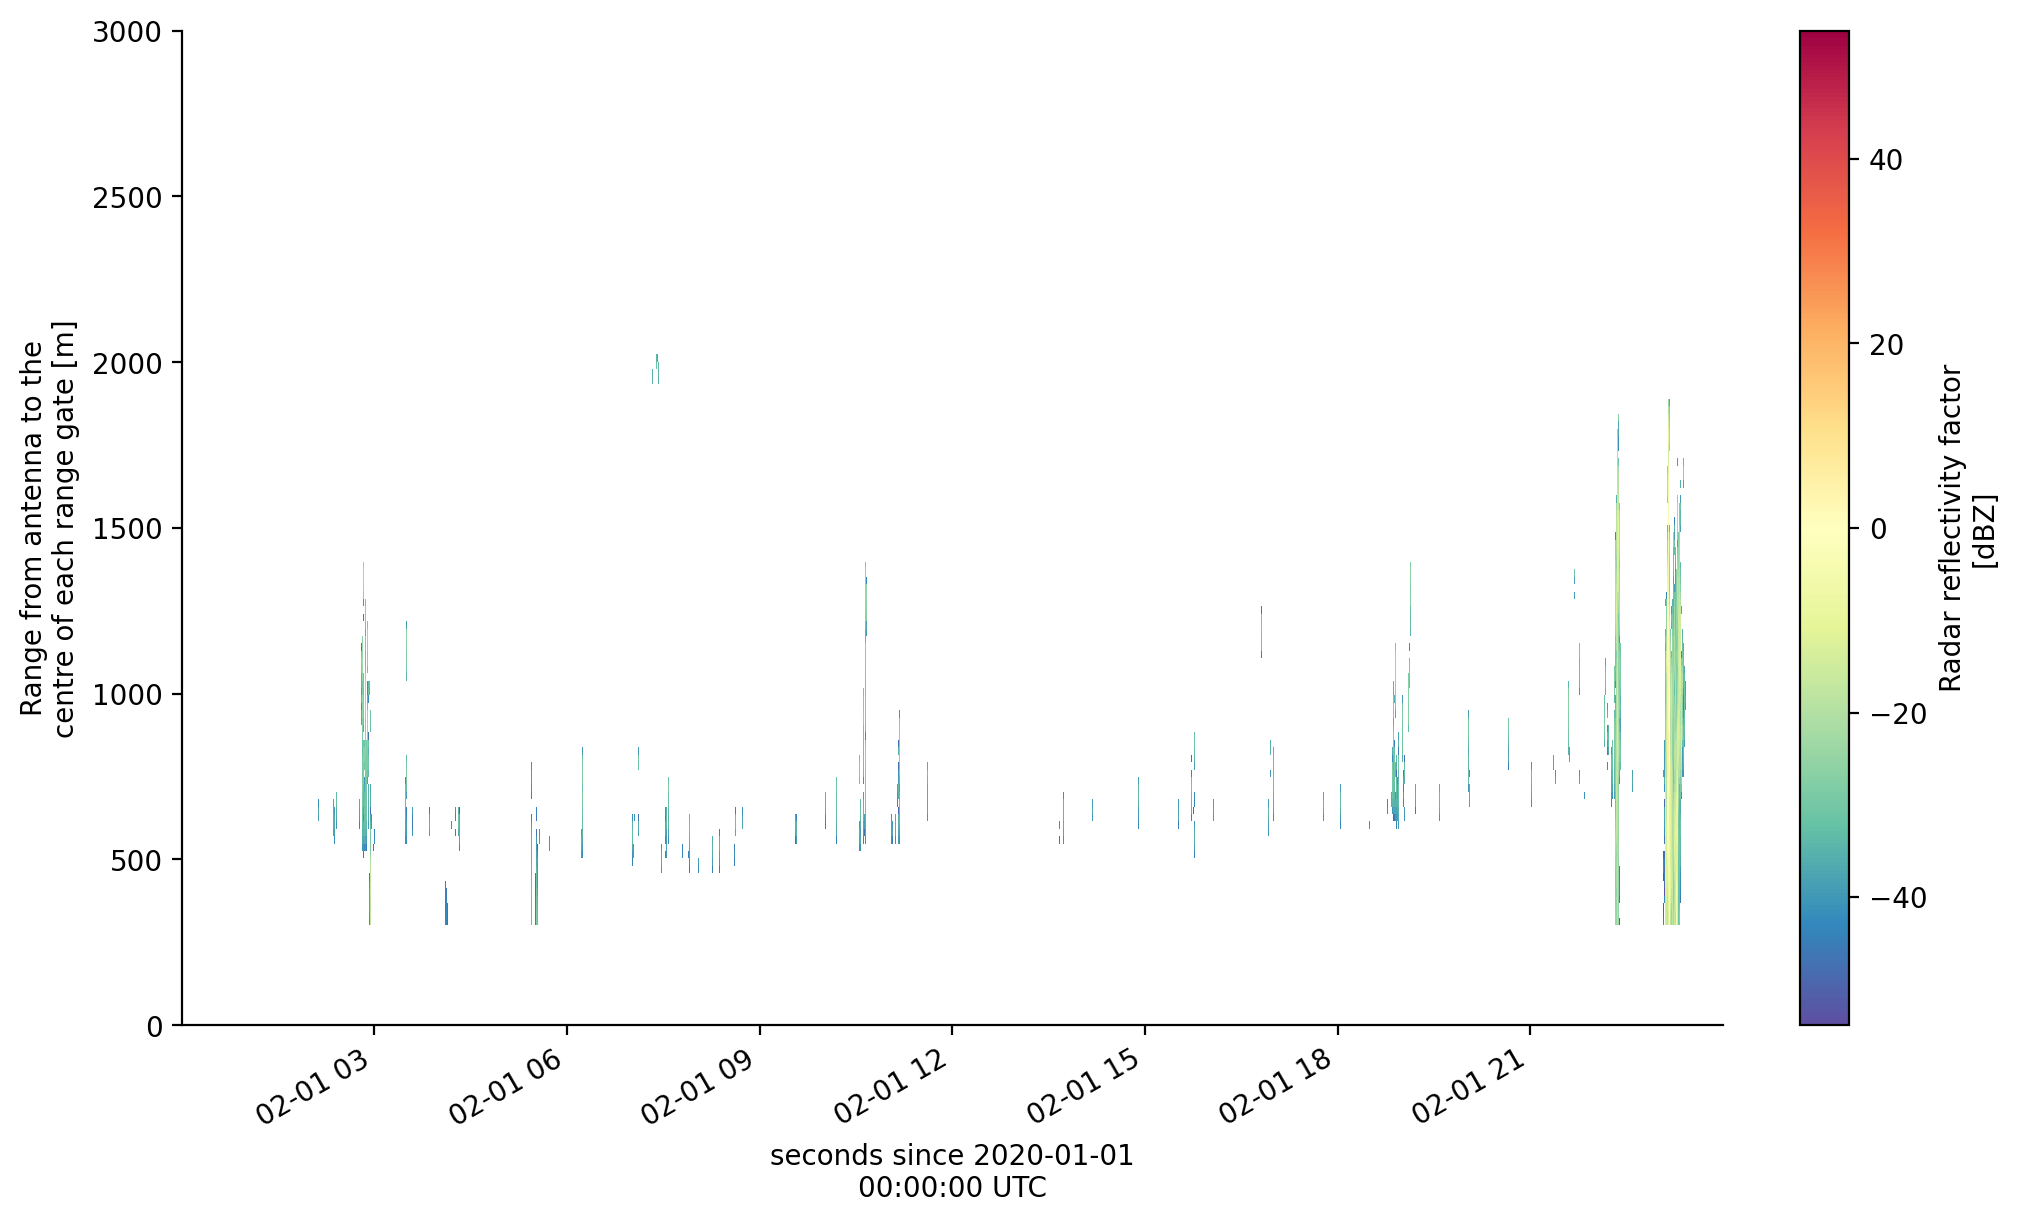

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("./mplstyle/book")

ds.Zh.plot(x='time', cmap="Spectral_r")  # plot the variable with time as the x axis
plt.ylim(0, 3000);